<a href="https://colab.research.google.com/github/gudes-marcia/Google-Ads-Classification/blob/main/Classification_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Libraries

In [ ]:
import pandas as pd
import seaborn as srn
import statistics  as sts
import matplotlib.pyplot as plt
import numpy as np
import pickle
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, accuracy_score, confusion_matrix
from graphviz import Digraph
from IPython.display import Image

# Dataset Upload

In [ ]:
url = 'https://docs.google.com/spreadsheets/d/1M89WOPX-krEjzRs7zvjTxZqF9EUuxXW0vjXARdn-e4w/gviz/tq?tqx=out:csv'

In [ ]:
dataset = pd.read_csv(url)

In [ ]:
dataset.head()

,Product,Clicks,Impressions,CPC,Conversions,Product Price,IQ
0,Product 1,348.0,4045,$1.50,11,49,6.0
1,Product 2,271.0,2205,$1.40,16,60,7.0
2,Product 3,767.0,10285,$1.12,40,67,7.0
3,Product 4,399.0,5555,$1.12,19,56,6.0
4,Product 5,537.0,7777,$1.12,28,61,7.0


# Data Exploration

In [ ]:
# Size
dataset.shape

(500, 7)

In [ ]:
# Data Type
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Product        500 non-null    object 
 1   Clicks         499 non-null    float64
 2   Impressions    500 non-null    int64  
 3   CPC            499 non-null    object 
 4   Conversions    500 non-null    int64  
 5   Product Price  500 non-null    int64  
 6   IQ             499 non-null    float64
dtypes: float64(2), int64(3), object(2)
memory usage: 27.5+ KB
None


In [ ]:
# Statistical Description
dataset.describe()

,Clicks,Impressions,Conversions,Product Price,IQ
count,499.000000,500.000000,500.000000,500.000000,499.000000
mean,589.042084,7073.748000,28.224000,43.444000,7.254509
std,233.816528,3655.743075,11.949368,15.074925,1.260042
min,202.000000,2004.000000,8.000000,11.000000,5.000000
25%,376.500000,4254.750000,18.000000,30.000000,7.000000
50%,583.000000,6358.000000,28.000000,43.000000,7.000000
75%,780.000000,8835.000000,36.250000,56.000000,8.000000
max,1000.000000,18411.000000,58.000000,70.000000,10.000000


# Data Cleaning

In [ ]:
# Removal of Irrelevant Columns
dataset = dataset.drop(['Product'], axis=1)

In [ ]:
# Rename Columns
dataset = dataset.rename(columns={'IQ': 'Quality Score'})

In [ ]:
dataset.head()

,Clicks,Impressions,CPC,Conversions,Product Price,Quality Score
0,348.0,4045,$1.50,11,49,6.0
1,271.0,2205,$1.40,16,60,7.0
2,767.0,10285,$1.12,40,67,7.0
3,399.0,5555,$1.12,19,56,6.0
4,537.0,7777,$1.12,28,61,7.0


In [ ]:
# Removal of Symbols ($, %)
dataset['CPC'] = dataset['CPC'].str.replace('[^\d.]', '', regex=True)
print(dataset['CPC'])

0      1.50
1      1.40
2      1.12
3      1.12
4      1.12
       ... 
495    1.13
496    1.13
497    1.12
498    1.12
499    1.12
Name: CPC, Length: 500, dtype: object


In [ ]:
# Check NAN
dataset.isnull().sum()

,0
Clicks,1
Impressions,0
CPC,1
Conversions,0
Product Price,0
Quality Score,1


In [ ]:
# Replacement of Nulls with Median Values
mediana_clicks = dataset['Clicks'].median()
dataset['Clicks'].fillna(mediana_clicks, inplace=True)
mediana_cpc = dataset['CPC'].median()
dataset['CPC'].fillna(mediana_cpc, inplace=True)
mediana_qs = dataset['Quality Score'].median()
dataset['Quality Score'].fillna(mediana_qs, inplace=True)

In [ ]:
dataset.isnull().sum()

,0
Clicks,0
Impressions,0
CPC,0
Conversions,0
Product Price,0
Quality Score,0


In [ ]:
# Checking for duplicates
num_dup = dataset.duplicated().sum()
print(num_dup)

0


# Data Transformation

In [ ]:
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Clicks         500 non-null    float64
 1   Impressions    500 non-null    int64  
 2   CPC            500 non-null    object 
 3   Conversions    500 non-null    int64  
 4   Product Price  500 non-null    int64  
 5   Quality Score  500 non-null    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 23.6+ KB
None


In [ ]:
# Converting Object to Numeric
dataset['CPC'] = pd.to_numeric(dataset['CPC'], errors='coerce')
print(dataset['CPC'])

0      1.50
1      1.40
2      1.12
3      1.12
4      1.12
       ... 
495    1.13
496    1.13
497    1.12
498    1.12
499    1.12
Name: CPC, Length: 500, dtype: float64


In [ ]:
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Clicks         500 non-null    float64
 1   Impressions    500 non-null    int64  
 2   CPC            500 non-null    float64
 3   Conversions    500 non-null    int64  
 4   Product Price  500 non-null    int64  
 5   Quality Score  500 non-null    float64
dtypes: float64(3), int64(3)
memory usage: 23.6 KB
None


# Feature Engineering

In [ ]:
dataset['Spend'] = dataset['CPC'] * dataset['Clicks']

In [ ]:
dataset['CTR'] = (dataset['Clicks'] / dataset['Impressions']) * 100

In [ ]:
dataset['CPA'] = dataset['Spend'] / dataset['Conversions']

In [ ]:
dataset['CVR'] = (dataset['Conversions'] / dataset['Clicks']) * 100

In [ ]:
dataset['Revenue'] = dataset['Product Price'] * dataset['Conversions']

In [ ]:
dataset['ROAS'] = dataset['Revenue'] / dataset['Spend']

In [ ]:
dataset['ROAS >= 3'] = dataset['ROAS'].apply(lambda x: 'Yes' if x >= 3 else 'No')

In [ ]:
dataset['ROAS >= 3'] = dataset['ROAS >= 3'].map({'Yes': 1, 'No': 0})

In [ ]:
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Clicks         500 non-null    float64
 1   Impressions    500 non-null    int64  
 2   CPC            500 non-null    float64
 3   Conversions    500 non-null    int64  
 4   Product Price  500 non-null    int64  
 5   Quality Score  500 non-null    float64
 6   Spend          500 non-null    float64
 7   CTR            500 non-null    float64
 8   CPA            500 non-null    float64
 9   CVR            500 non-null    float64
 10  Revenue        500 non-null    int64  
 11  ROAS           500 non-null    float64
 12  ROAS >= 3      500 non-null    int64  
dtypes: float64(8), int64(5)
memory usage: 50.9 KB
None


In [ ]:
dataset.head()

,Clicks,Impressions,CPC,Conversions,Product Price,Quality Score,Spend,CTR,CPA,CVR,Revenue,ROAS,ROAS >= 3
0,348.0,4045,1.50,11,49,6.0,522.00,8.603214,47.454545,3.160920,539,1.032567,0
1,271.0,2205,1.40,16,60,7.0,379.40,12.290249,23.712500,5.904059,960,2.530311,0
2,767.0,10285,1.12,40,67,7.0,859.04,7.457462,21.476000,5.215124,2680,3.119762,1
3,399.0,5555,1.12,19,56,6.0,446.88,7.182718,23.520000,4.761905,1064,2.380952,0
4,537.0,7777,1.12,28,61,7.0,601.44,6.904976,21.480000,5.214153,1708,2.839851,0


# Data Visualization

In [ ]:
# Statistical Description
dataset.describe()

,Clicks,Impressions,CPC,Conversions,Product Price,Quality Score,Spend,CTR,CPA,CVR,Revenue,ROAS,ROAS >= 3
count,500.000000,500.000000,500.00000,500.000000,500.000000,500.00000,500.00000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,589.030000,7073.748000,1.35888,28.224000,43.444000,7.25400,879.54872,8.967675,29.489859,4.849527,1226.268000,2.663410,0.332000
std,233.582282,3655.743075,11.14481,11.949368,15.074925,1.25883,8344.36570,2.392384,245.252412,0.893427,694.493853,1.346705,0.471403
min,202.000000,2004.000000,0.44000,8.000000,11.000000,5.00000,112.50000,5.007481,8.184000,1.372213,165.000000,0.010182,0.000000
25%,376.750000,4254.750000,0.64000,18.000000,30.000000,7.00000,306.47750,7.301359,13.450161,4.320988,680.000000,1.641455,0.000000
50%,583.000000,6358.000000,0.82000,28.000000,43.000000,7.00000,448.60000,8.859212,17.278365,4.920574,1060.000000,2.438319,0.000000
75%,779.500000,8835.000000,1.10000,36.250000,56.000000,8.00000,648.27000,10.610200,21.940672,5.645761,1651.500000,3.380734,1.000000
max,1000.000000,18411.000000,250.00000,58.000000,70.000000,10.00000,187000.00000,14.956737,5500.000000,6.052270,3710.000000,7.445590,1.000000


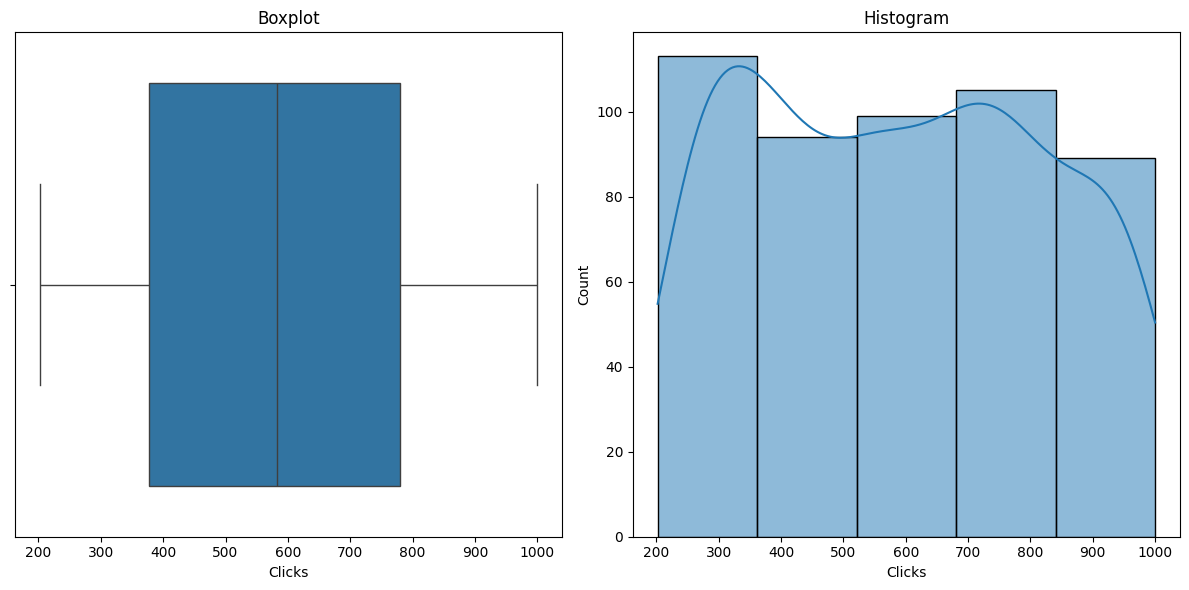

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
srn.boxplot(x=dataset['Clicks'], ax=ax[0])
ax[0].set_title('Boxplot')
srn.histplot(dataset['Clicks'], bins=5, kde=True, ax=ax[1])
ax[1].set_title('Histogram')
plt.tight_layout()
plt.show()

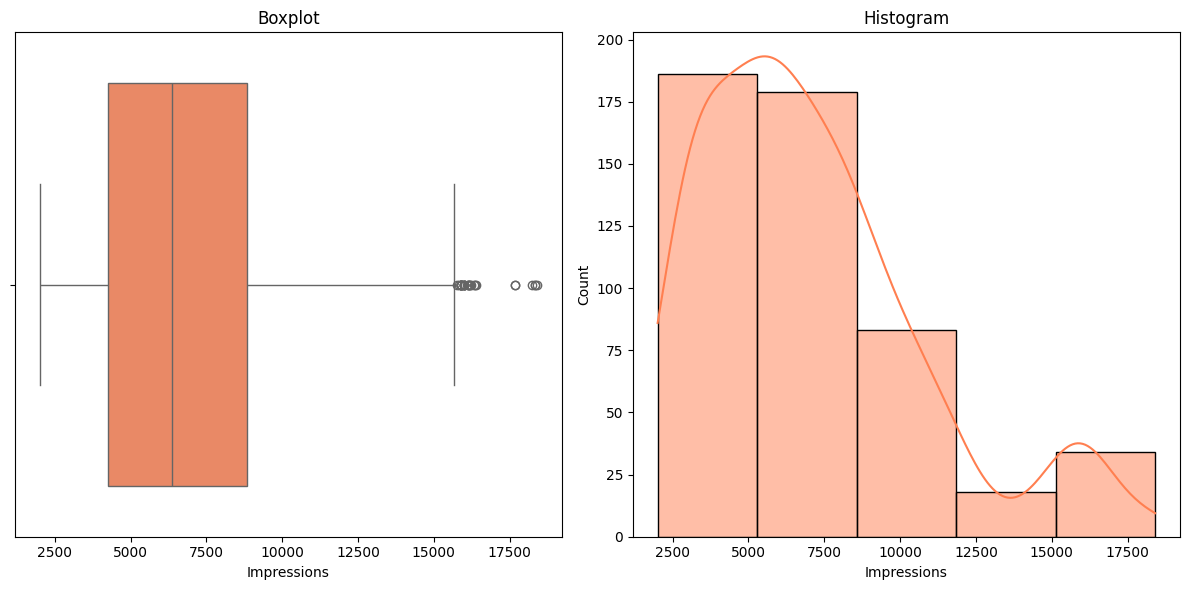

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
srn.boxplot(x=dataset['Impressions'], ax=ax[0],color='coral')
ax[0].set_title('Boxplot')
srn.histplot(dataset['Impressions'], bins=5, kde=True, ax=ax[1],color='coral')
ax[1].set_title('Histogram')
plt.tight_layout()
plt.show()

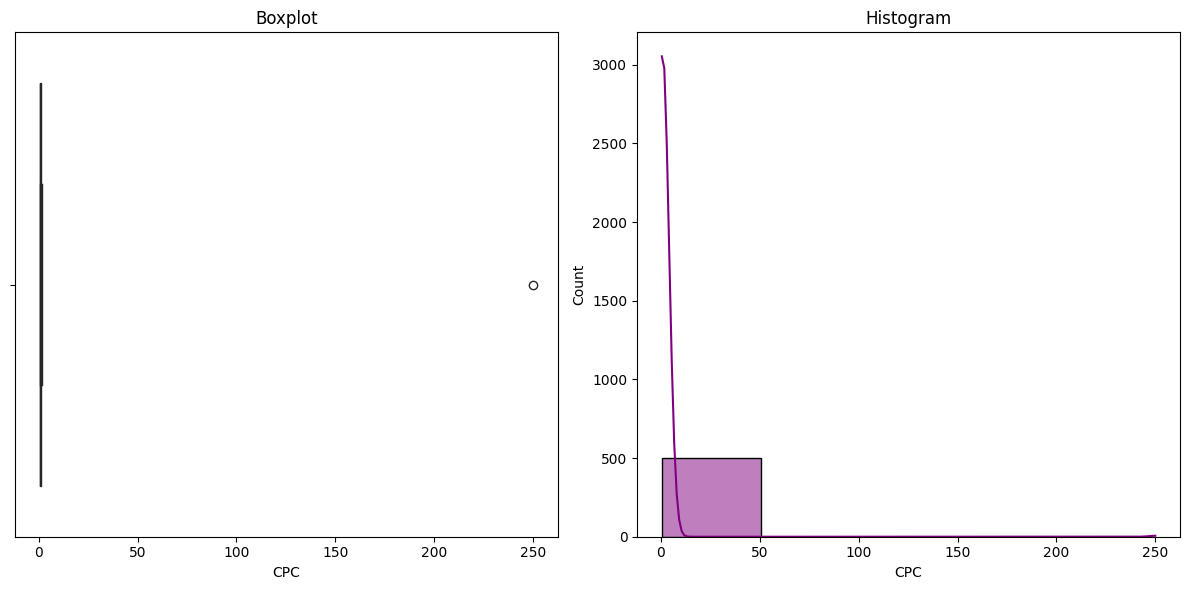

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
srn.boxplot(x=dataset['CPC'], ax=ax[0],color='purple')
ax[0].set_title('Boxplot')
srn.histplot(dataset['CPC'], bins=5, kde=True, ax=ax[1],color='purple')
ax[1].set_title('Histogram')
plt.tight_layout()
plt.show()

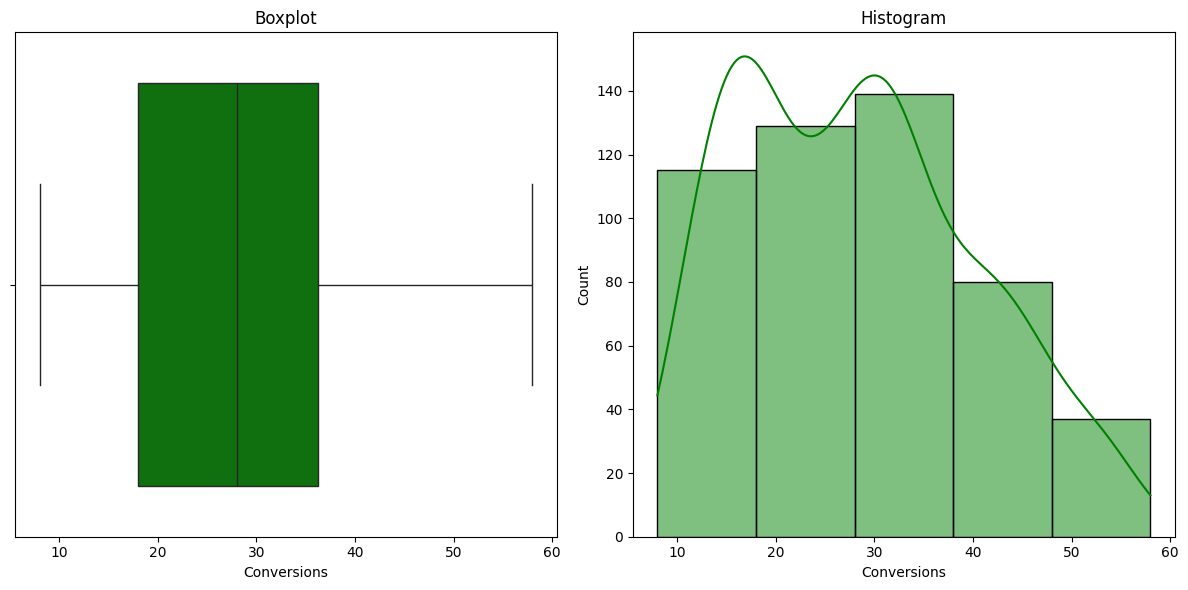

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
srn.boxplot(x=dataset['Conversions'], ax=ax[0],color='green')
ax[0].set_title('Boxplot')
srn.histplot(dataset['Conversions'], bins=5, kde=True, ax=ax[1],color='green')
ax[1].set_title('Histogram')
plt.tight_layout()
plt.show()

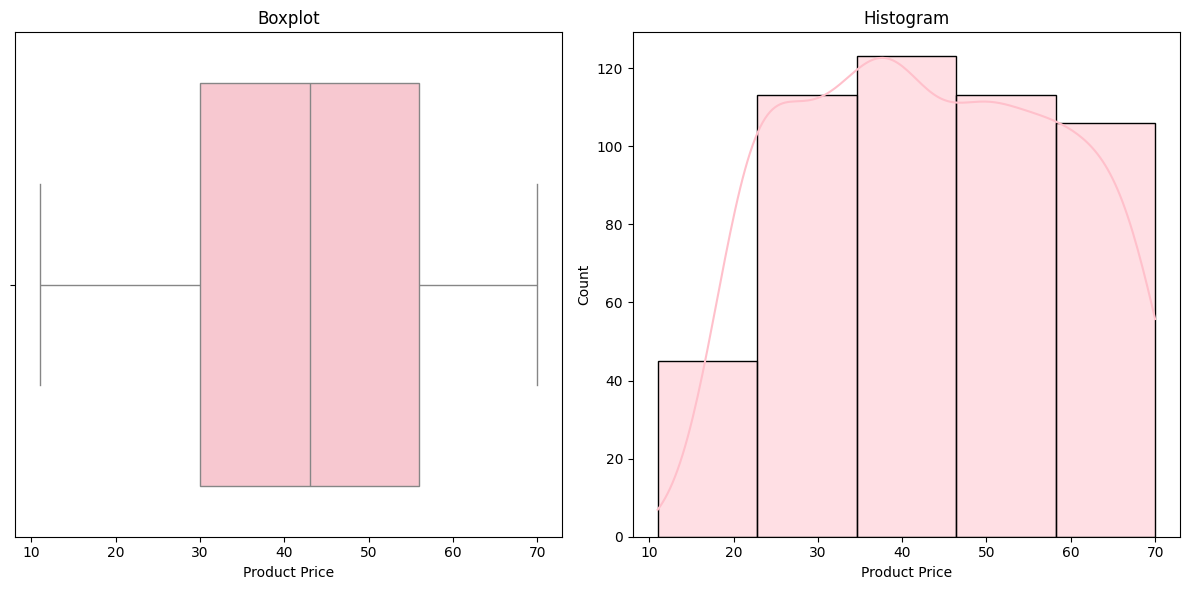

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
srn.boxplot(x=dataset['Product Price'], ax=ax[0],color='pink')
ax[0].set_title('Boxplot')
srn.histplot(dataset['Product Price'], bins=5, kde=True, ax=ax[1],color='pink')
ax[1].set_title('Histogram')
plt.tight_layout()
plt.show()

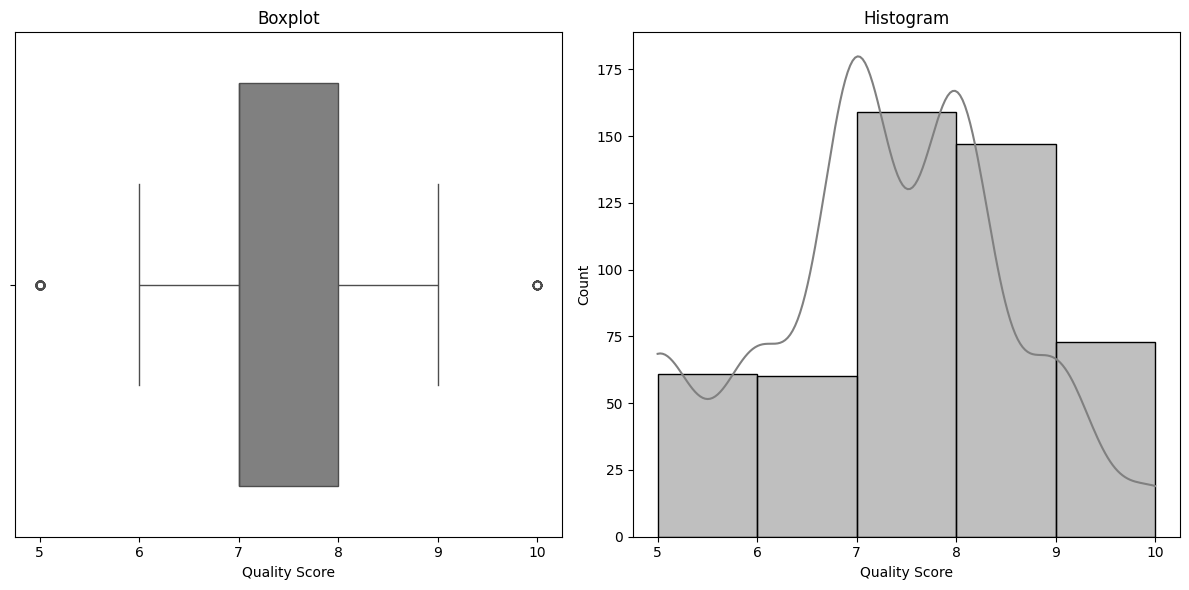

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
srn.boxplot(x=dataset['Quality Score'], ax=ax[0],color='gray')
ax[0].set_title('Boxplot')
srn.histplot(dataset['Quality Score'], bins=5, kde=True, ax=ax[1],color='gray')
ax[1].set_title('Histogram')
plt.tight_layout()
plt.show()

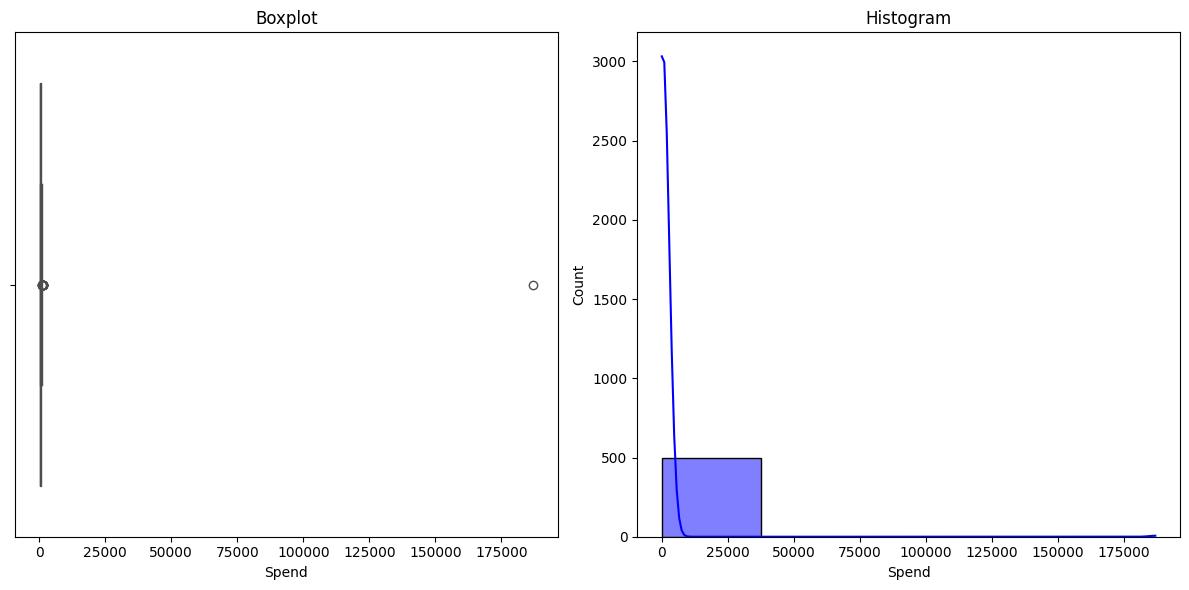

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
srn.boxplot(x=dataset['Spend'], ax=ax[0],color='blue')
ax[0].set_title('Boxplot')
srn.histplot(dataset['Spend'], bins=5, kde=True, ax=ax[1],color='blue')
ax[1].set_title('Histogram')
plt.tight_layout()
plt.show()

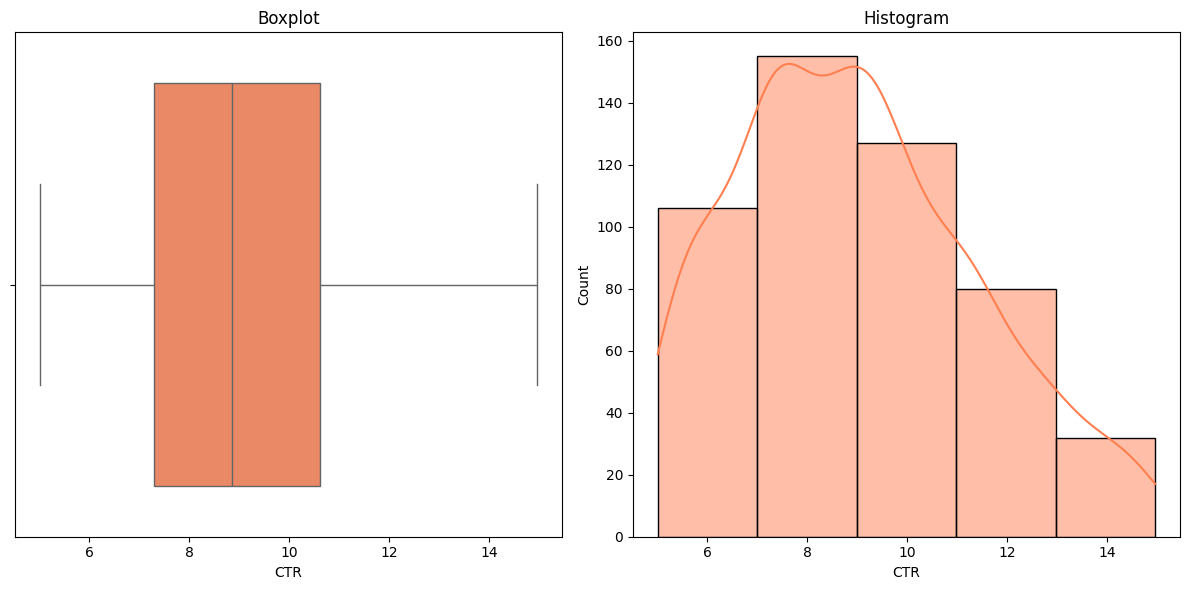

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
srn.boxplot(x=dataset['CTR'], ax=ax[0],color='coral')
ax[0].set_title('Boxplot')
srn.histplot(dataset['CTR'], bins=5, kde=True, ax=ax[1],color='coral')
ax[1].set_title('Histogram')
plt.tight_layout()
plt.show()

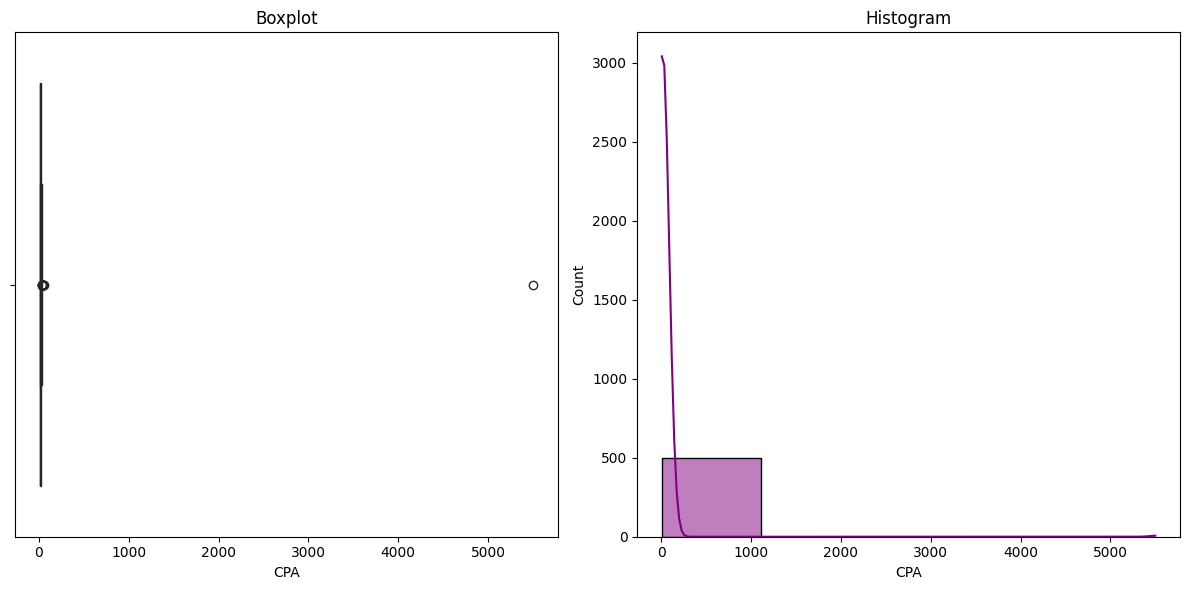

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
srn.boxplot(x=dataset['CPA'], ax=ax[0],color='purple')
ax[0].set_title('Boxplot')
srn.histplot(dataset['CPA'], bins=5, kde=True, ax=ax[1],color='purple')
ax[1].set_title('Histogram')
plt.tight_layout()
plt.show()

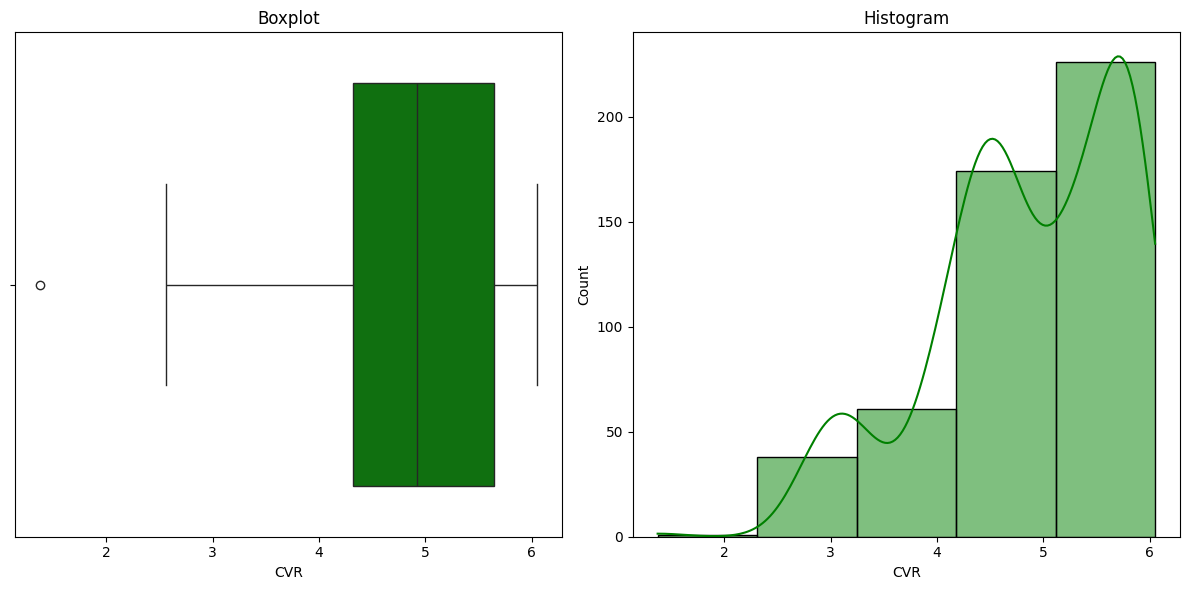

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
srn.boxplot(x=dataset['CVR'], ax=ax[0],color='green')
ax[0].set_title('Boxplot')
srn.histplot(dataset['CVR'], bins=5, kde=True, ax=ax[1],color='green')
ax[1].set_title('Histogram')
plt.tight_layout()
plt.show()

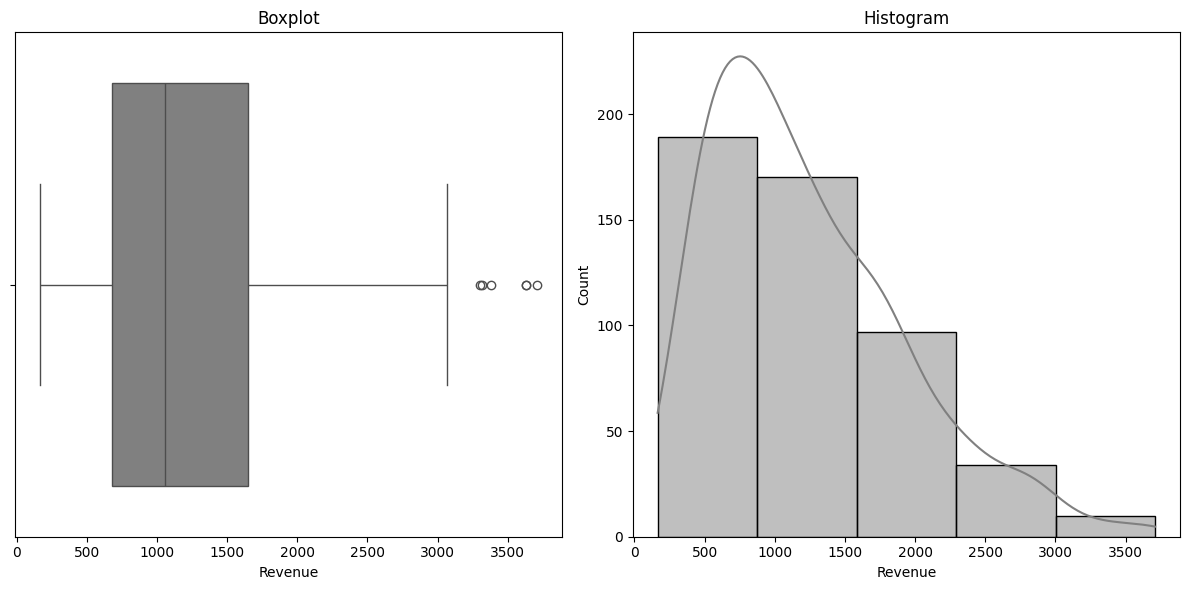

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
srn.boxplot(x=dataset['Revenue'], ax=ax[0],color='gray')
ax[0].set_title('Boxplot')
srn.histplot(dataset['Revenue'], bins=5, kde=True, ax=ax[1],color='gray')
ax[1].set_title('Histogram')
plt.tight_layout()
plt.show()

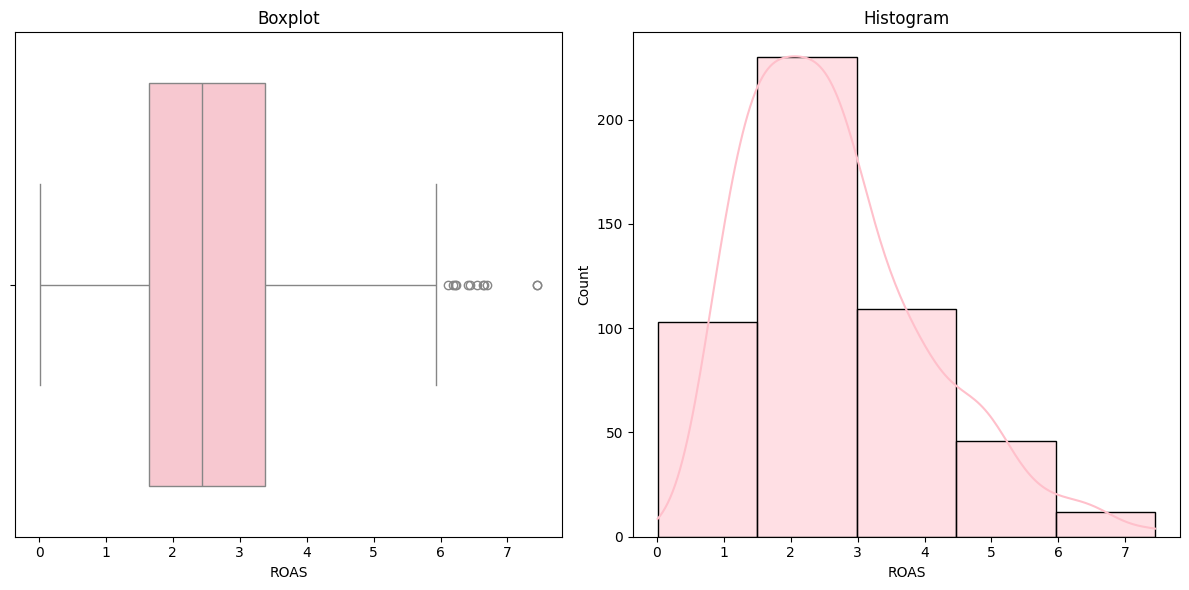

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
srn.boxplot(x=dataset['ROAS'], ax=ax[0],color='pink')
ax[0].set_title('Boxplot')
srn.histplot(dataset['ROAS'], bins=5, kde=True, ax=ax[1],color='pink')
ax[1].set_title('Histogram')
plt.tight_layout()
plt.show()

# Data Treatment

In [ ]:
Q1 = dataset['CPC'].quantile(0.25)
Q3 = dataset['CPC'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR
out_cpc = dataset[(dataset['CPC'] < limite_inferior) | (dataset['CPC'] > limite_superior)]
print(out_cpc)

     Clicks  Impressions    CPC  Conversions  Product Price  Quality Score  \
266   748.0        10241  250.0           34             56            6.0   

        Spend       CTR     CPA       CVR  Revenue      ROAS  ROAS >= 3  
266  187000.0  7.303974  5500.0  4.545455     1904  0.010182          0  


In [ ]:
# Removing Outliers
dataset = dataset[(dataset['CPC'] >= limite_inferior) & (dataset['CPC'] <= limite_superior)]
dataset.shape

(499, 13)

<Axes: xlabel='CPC'>

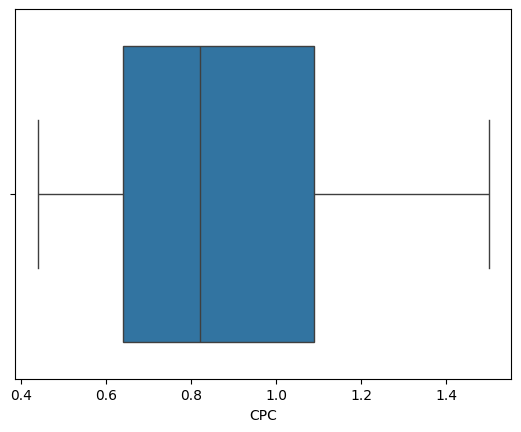

In [ ]:
srn.boxplot(x=dataset['CPC'])

# Machine Learning

## Defining Variables

In [ ]:
class_distribution = dataset['ROAS >= 3'].value_counts()
print(class_distribution)

ROAS >= 3
0    333
1    166
Name: count, dtype: int64


In [ ]:
X = dataset[[ 'CPC', 'Product Price', 'Quality Score', 'Spend', 'CTR', 'CVR']]
y = dataset['ROAS >= 3']

## Training and Test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Normalization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Class balancing
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

In [ ]:
print("Class distribution in the training set after SMOTE:")
print(pd.Series(y_train_smote).value_counts())

Class distribution in the training set after SMOTE:
ROAS >= 3
0    264
1    264
Name: count, dtype: int64


## Classification Model

In [ ]:
log_reg = LogisticRegression()
log_reg.fit(X_train_smote, y_train_smote)

LogisticRegression()

In [ ]:
y_pred = log_reg.predict(X_test_scaled)
y_pred_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

## Model Evaluation

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)
class_report = classification_report(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")
print("\n--- Confusion Matrix ---")
print("Confusion Matrix:\n", conf_matrix)
print("True Negatives (TN):", conf_matrix[0, 0])
print("False Positives (FP):", conf_matrix[0, 1])
print("False Negatives (FN):", conf_matrix[1, 0])
print("True Positives (TP):", conf_matrix[1, 1])
print(f"ROC AUC Score: {roc_auc:.2f}")
print("\n--- Classification Report ---")
print(class_report)

Model Accuracy: 99.00%

--- Confusion Matrix ---
Confusion Matrix:
 [[69  0]
 [ 1 30]]
True Negatives (TN): 69
False Positives (FP): 0
False Negatives (FN): 1
True Positives (TP): 30
ROC AUC Score: 1.00

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        69
           1       1.00      0.97      0.98        31

    accuracy                           0.99       100
   macro avg       0.99      0.98      0.99       100
weighted avg       0.99      0.99      0.99       100



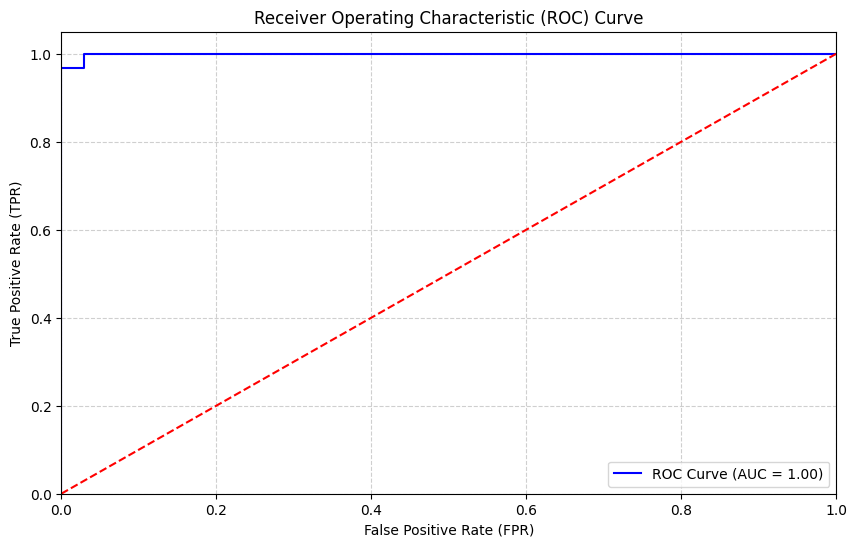

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal dashed line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [ ]:
# Check the range of predicted probabilities
min_prob = y_pred_prob.min()
max_prob = y_pred_prob.max()
print("Range of predicted probabilities:")
print(f"Min: {min_prob:.10f}, Max: {max_prob:.10f}")
print("\nInterpretation:")
if min_prob < 0.01 and max_prob > 0.99:
    print("The predicted probabilities span from near 0 to near 1, which indicates that the model is generating a wide range of confidence levels.")
    print("This suggests that the model is effectively distinguishing between classes and should produce a meaningful ROC curve.")
else:
    print("The range of predicted probabilities is not as wide as expected.")
    print("This might indicate that the model is not distinguishing well between classes or may need further adjustment.")


Range of predicted probabilities:
Min: 0.0000000001, Max: 0.9999491613

Interpretation:
The predicted probabilities span from near 0 to near 1, which indicates that the model is generating a wide range of confidence levels.
This suggests that the model is effectively distinguishing between classes and should produce a meaningful ROC curve.


In [ ]:
# Evaluate model on training and test sets
y_train_pred = log_reg.predict(X_train_smote)
y_train_pred_prob = log_reg.predict_proba(X_train_smote)[:, 1]

print("Training Accuracy:", accuracy_score(y_train_smote, y_train_pred))
print("Training ROC AUC Score:", roc_auc_score(y_train_smote, y_train_pred_prob))

print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("Test ROC AUC Score:", roc_auc_score(y_test, y_pred_prob))

print("\n--- Additional Evaluation Metrics Explained ---")
print("1. **ROC AUC Score**: A measure of how well the model distinguishes between classes. Closer to 1 is better.")

Training Accuracy: 0.9886363636363636
Training ROC AUC Score: 0.9998134756657484

Test Accuracy: 0.99
Test ROC AUC Score: 0.9990649836372136

--- Additional Evaluation Metrics Explained ---
1. **ROC AUC Score**: A measure of how well the model distinguishes between classes. Closer to 1 is better.


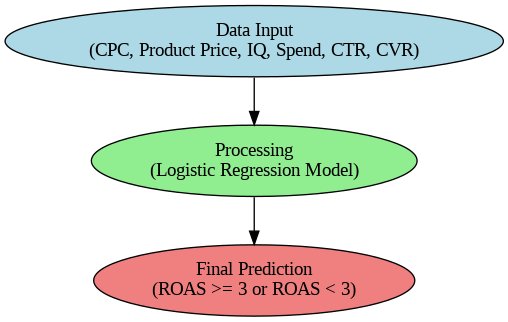

In [ ]:
# Create the flowchart
dot = Digraph()

# Add the blocks with different colors
dot.node('A', 'Data Input\n(CPC, Product Price, IQ, Spend, CTR, CVR)', shape='ellipse', style='filled', fillcolor='lightblue')
dot.node('B', 'Processing\n(Logistic Regression Model)', shape='ellipse', style='filled', fillcolor='lightgreen')
dot.node('C', 'Final Prediction\n(ROAS >= 3 or ROAS < 3)', shape='ellipse', style='filled', fillcolor='lightcoral')

# Add the arrows between blocks
dot.edge('A', 'B')
dot.edge('B', 'C')

# Render the diagram
dot.render('flow_diagram', format='png', cleanup=True)

# Display the diagram
Image('flow_diagram.png')




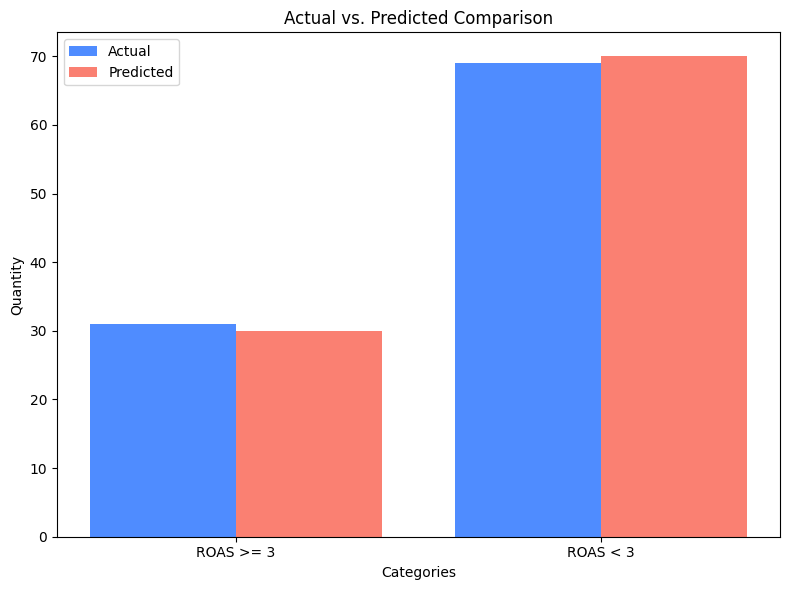

In [ ]:
labels = ['ROAS >= 3', 'ROAS < 3']
real_counts = [sum(y_test == 1), sum(y_test == 0)]  # Actual
predicted_counts = [sum(y_pred == 1), sum(y_pred == 0)]  # Predicted
x = np.arange(len(labels))

plt.figure(figsize=(8, 6))

plt.bar(x - 0.2, real_counts, width=0.4, label='Actual',color='#4F8CFF')
plt.bar(x + 0.2, predicted_counts, width=0.4, label='Predicted', color='salmon')

plt.xticks(x, labels)
plt.xlabel('Categories')
plt.ylabel('Quantity')
plt.title('Actual vs. Predicted Comparison')
plt.legend()

plt.tight_layout()
plt.show()


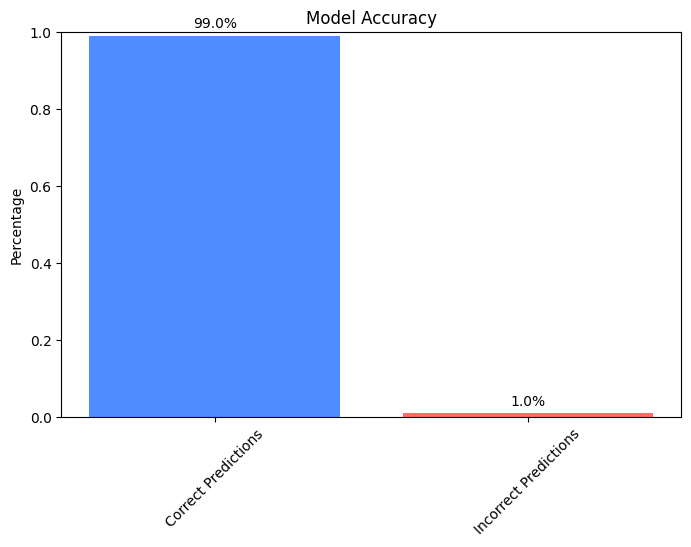

In [ ]:
# Data for the bar chart
labels = ['Correct Predictions', 'Incorrect Predictions']
values = [accuracy, 1 - accuracy]

# Creating the bar chart
plt.figure(figsize=(8, 5))
plt.bar(labels, values, color=['#4F8CFF', '#FF6F61'])
plt.ylim(0, 1)

# Adding titles and labels
plt.title('Model Accuracy')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.text(0, accuracy + 0.02, f'{accuracy * 100:.1f}%', ha='center', color='black')
plt.text(1, (1 - accuracy) + 0.02, f'{(1 - accuracy) * 100:.1f}%', ha='center', color='black')

plt.show()


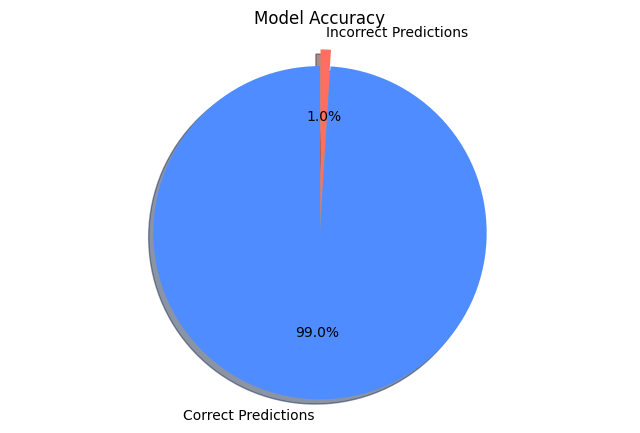

In [ ]:
# Data for the pie chart
sizes = [accuracy, 1 - accuracy]
labels = ['Correct Predictions', 'Incorrect Predictions']
colors = ['#4F8CFF', '#FF6F61']
explode = (0.1, 0)  # explode the 1st slice (Correct Predictions)

# Creating the pie chart
plt.figure(figsize=(8, 5))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Model Accuracy')
plt.show()


## Data Input and Results


In [ ]:
data_input = pd.DataFrame({
    'CPC': [0.75],
    'Product Price': [40],
    'Quality Score': [8],
    'Spend': [337.5],
    'CTR': [9.0],
    'CVR': [4.0]
})

In [ ]:
data_input_scaled = scaler.transform(data_input)

In [ ]:
predictions = log_reg.predict(data_input_scaled)
predicted_probabilities = log_reg.predict_proba(data_input_scaled)[:, 1]

In [ ]:
predictions_labels = ['Yes' if prob > 0.5 else 'No' for prob in predicted_probabilities]


In [ ]:
results = data_input.copy()
results['Predicted'] = predictions_labels
results['Probability'] = predicted_probabilities

In [ ]:
print("\nPrediction Results For input data:")
for i, row in results.iterrows():
    print(f"\nCPC: {row['CPC']}, Product Price: {row['Product Price']}, IQ: {row['Quality Score']}, Spend: {row['Spend']}, CTR: {row['CTR']}, CVR: {row['CVR']}")
    print(f"Predicted class: {row['Predicted']}")
    print("Test Accuracy:", accuracy_score(y_test, y_pred))
    print(f"Predicted probability of 'ROAS 3 or Higher': {row['Probability']:.4f}")
    if row['Probability'] > 0.5:
        print("Interpretation: The model is confident that this data point falls into 'ROAS 3 or Higher'.")
    else:
        print("Interpretation: The model is confident that this data point falls into 'ROAS Less than 3'.")


Prediction Results For input data:

CPC: 0.75, Product Price: 40, IQ: 8, Spend: 337.5, CTR: 9.0, CVR: 4.0
Predicted class: No
Test Accuracy: 0.99
Predicted probability of 'ROAS 3 or Higher': 0.0217
Interpretation: The model is confident that this data point falls into 'ROAS 3 or Less'.


## User Data Input and Results

In [ ]:
cpc = float(input("Enter CPC: "))
product_price = float(input("Enter Product Price: "))
iq = float(input("Enter Quality Score: "))
spend = float(input("Enter Spend: "))
ctr = float(input("Enter CTR: "))
cvr = float(input("Enter CVR: "))


Enter CPC: 1
Enter Product Price: 50
Enter Quality Score: 5
Enter Spend: 500
Enter CTR: 15
Enter CVR: 6


In [ ]:
user_input = pd.DataFrame([[cpc, product_price, iq, spend, ctr, cvr]], columns=['CPC', 'Product Price', 'Quality Score', 'Spend', 'CTR', 'CVR'])


In [ ]:
user_input_scaled = scaler.transform(user_input)

In [ ]:
prob = log_reg.predict_proba(user_input_scaled)[0, 1]
pred_class = 'ROAS 3 or Higher' if prob > 0.5 else 'Less than ROAS 3'

In [ ]:
results = user_input.copy()
results['Predicted'] = pred_class
results['Probability'] = prob

In [ ]:
print("\nPrediction Results For User data:")
for i, row in results.iterrows():
    print(f"\nCPC: {row['CPC']}, Product Price: {row['Product Price']}, IQ: {row['Quality Score']}, Spend: {row['Spend']}, CTR: {row['CTR']}, CVR: {row['CVR']}")
    print(f"Predicted class: {row['Predicted']}")
    print("Test Accuracy:", accuracy_score(y_test, y_pred))
    print(f"Predicted probability of class 'Yes': {row['Probability']:.4f}")

    if row['Probability'] > 0.5:
        print("Interpretation: The model is confident that this data point falls into 'ROAS 3 or Higher.")
    else:
        print("Interpretation: The model is confident that this data point falls into 'ROAS Less than 3'.")


Prediction Results For User data:

CPC: 1.0, Product Price: 50.0, IQ: 5.0, Spend: 500.0, CTR: 15.0, CVR: 6.0
Predicted class: Less than ROAS 3
Test Accuracy: 0.99
Predicted probability of class 'Yes': 0.3001
Interpretation: The model is confident that this data point falls into 'ROAS Less than 3'.
